In [1]:
import sys
quic_path = '/home/quic/QUIC-Projects'
if not quic_path in sys.path:
    sys.path.append(quic_path)

In [2]:
import numpy as np 
from matplotlib import pyplot as plt

In [3]:
# for SVM
from classifiers.convex.svm import BinarySVM
from classifiers.kernel import Kernel
from classifiers.datasets.dataloader import Example_4x2
from classifiers.datasets import IrisDataset
# for QASVM
from classifiers.quantum.qasvm import QASVM, NormQSVM
from classifiers.quantum.ansatz import Circuit9, sample_circuit
from classifiers.optimizer import tSPSA
from classifiers.callback import CostParamStorage
from qiskit.utils import QuantumInstance
from qiskit.providers.aer import AerSimulator, StatevectorSimulator, Aer, QasmSimulator

In [4]:
ds = IrisDataset(feature_range=(-np.pi, np.pi), true_hot=0)
X, y = ds.sample(2**6, return_X_y=True)

In [5]:
backend = StatevectorSimulator(device='GPU')
backend.options

Options(shots=1, device='GPU', precision='double', executor=None, max_job_size=None, max_shot_size=None, zero_threshold=1e-10, validation_threshold=None, max_parallel_threads=None, max_parallel_experiments=None, max_parallel_shots=None, max_memory_mb=None, seed_simulator=None, fusion_enable=True, fusion_verbose=False, fusion_max_qubit=5, fusion_threshold=14, statevector_parallel_threshold=14)

In [6]:
_feature_map = Circuit9(X.shape[1], reps=1)
feature_map = _feature_map.copy()
for _ in range(2 - 1):
    feature_map.compose(_feature_map, inplace=True)

var_form = sample_circuit(15)(num_qubits=6, reps=5)
quantum_instance = QuantumInstance(backend=backend, shots=2**13)
qasvm = NormQSVM(
        X, y, lamda=1,
        quantum_instance=quantum_instance,
        var_form=var_form,
        feature_map=feature_map
    )
storage = CostParamStorage()

In [7]:
qasvm.cost_fn(qasvm.parameters)

0.1423668212652708

In [8]:
from qiskit.algorithms.optimizers import ADAM, SPSA
from tqdm.notebook import tqdm
MAXITER = 2**10

pbar = tqdm(total=MAXITER)

def callback(*args):
    storage(*args)
    pbar.update()

optimizer = SPSA(maxiter=MAXITER, callback=callback, last_avg=16)

opt_result = optimizer.minimize(fun=qasvm.cost_fn, x0=qasvm.initial_point, jac=qasvm.grad_fn)
pbar.close()

  0%|          | 0/1024 [00:00<?, ?it/s]

In [11]:
print(opt_result)

{   'fun': 0.032518951191511936,
    'jac': None,
    'nfev': 3072,
    'nit': None,
    'njev': None,
    'x': array([-0.73382402, -0.54642068, -3.85920876, -2.20608863,  2.66631398,
       -2.51388573,  1.0755247 ,  0.30774831,  1.06526339, -2.67512822,
        1.40641147,  0.60400886, -0.62643533, -1.95245856, -1.19365898,
       -3.47988306,  2.75973921, -0.29318762, -1.83947976, -4.02607737,
        2.21411046,  2.407811  , -0.80739082,  0.04506319, -0.48381792,
       -1.52110587,  0.06137395, -3.56197034,  1.83129536, -1.29624856])}


In [13]:
qasvm.parameters = storage.last_avg(16, True)
qasvm.accuracy(X, y)

0.9375

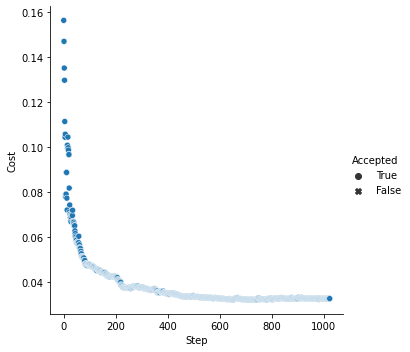

In [12]:
storage.plot()

In [20]:
from classifiers.quantum.qasvm import PseudoNormQSVM

pqasvm = PseudoNormQSVM(data=X, label=y, quantum_instance=quantum_instance, feature_map=feature_map, lamda=qasvm.lamda)
pstorage = CostParamStorage()

In [21]:
pqasvm.cost_fn(pqasvm.initial_point)

0.08315991883145023

In [22]:
pbar = tqdm(total=10*MAXITER)

def pcallback(*args):
    pstorage(*args)
    pbar.update()

poptimizer = SPSA(maxiter=10*MAXITER, callback=pcallback, last_avg=16)

popt_result = poptimizer.minimize(fun=pqasvm.cost_fn, x0=pqasvm.initial_point)
pbar.close()

  0%|          | 0/10240 [00:00<?, ?it/s]

In [23]:
print(popt_result)

{   'fun': 0.03472968633728051,
    'jac': None,
    'nfev': 30720,
    'nit': None,
    'njev': None,
    'x': array([ 8.87352535e-01, -2.33869520e-01, -7.61014594e-01,  3.63152951e+00,
        3.09465813e+00, -5.54458275e-03,  1.86279020e+00, -1.27604532e+00,
        2.07908171e-01,  3.91728598e+00, -1.11286862e+00,  3.72628673e-01,
        1.34772085e-02,  1.96782569e+00, -2.64620368e+00, -1.38778562e-02,
       -3.80111094e+00,  1.04238581e+00, -2.77973204e+00,  2.92359707e+00,
       -1.16021724e+00, -5.51098946e+00,  2.43019252e-02,  6.84855505e-03,
       -1.69899230e+00,  2.45216931e+00,  9.28417575e-01, -8.42635478e-01,
        1.15356772e+00, -1.49709827e-02, -2.81621736e-03, -2.45747248e+00,
        3.65914516e+00, -5.53887155e-03, -3.97823168e+00,  2.50131641e+00,
       -3.85778861e-01, -3.04154695e-03,  1.80752344e+00, -9.66107402e-04,
        5.44455617e-01,  4.70361793e-01, -2.19084579e+00, -5.29183885e-03,
        4.37862022e+00, -2.25641930e+00, -8.62959128e-02,  1.63

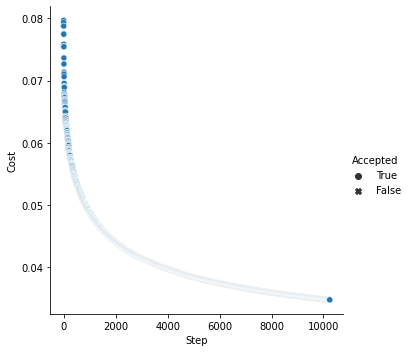

In [24]:
pstorage.plot()

In [25]:
pqasvm.parameters = pstorage.last_avg(16, True)
pqasvm.accuracy(X, y)

1.0

In [28]:
qasvm.cost_fn(qasvm.parameters)

0.03251895119151196

In [31]:
pqasvm.cost_fn(pqasvm.parameters)

0.03472968633728051

In [91]:
from classifiers.optimizer import Result2Dict

qasvm.save('./qasvm')
storage.save('./storage')
Result2Dict(opt_result).save_json('./opt_result.json')

pqasvm.save('./pqasvm')
pstorage.save('./pstorage')
Result2Dict(popt_result).save_json('./popt_result.json')

In [93]:
import qiskit.tools.jupyter
%qiskit_version_table